# Chapter 5. The Many Variables & The Spurious Waffles

In [1]:
import arviz as az
from causalgraphicalmodels import CausalGraphicalModel
import daft
import matplotlib.pyplot as plt
import numpy as onp
import pandas as pd

from jax import lax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro as npyro
from numpyro.contrib.autoguide import (AutoContinuousELBO,
                                       AutoLaplaceApproximation)
from numpyro.diagnostics import print_summary
import numpyro.distributions as dist
from numpyro.infer import Predictive, SVI
import numpyro.optim as optim

%config InlineBackend.figure_formats = ["svg"]
az.style.use("arviz-darkgrid")

### Code 5.1

In [2]:
# load data and copy
WaffleDivorce = pd.read_csv("../data/WaffleDivorce.csv", sep=";")
d = WaffleDivorce

# standardize variables
d["A"] = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std())
d["D"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std())

### Code 5.2

In [3]:
d.MedianAgeMarriage.std()

1.2436303013880823

### Code 5.3

In [4]:
def model(A, D=None):
    a = npyro.sample("a", dist.Normal(0, 0.2))
    bA = npyro.sample("bA", dist.Normal(0, 0.5))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a + bA * A
    npyro.sample("mu", dist.Delta(mu), obs=mu)
    npyro.sample("D", dist.Normal(mu, sigma), obs=D)

m5_1 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_1, optim.Adam(1), AutoContinuousELBO(),
          A=d.A.values, D=d.D.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p5_1 = svi.get_params(state)

### Code 5.4

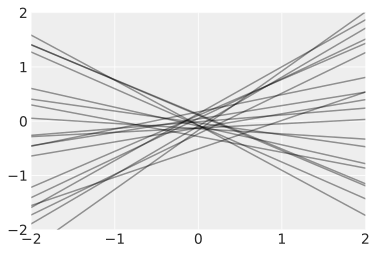

In [5]:
predictive = Predictive(m5_1.model, num_samples=1000, return_sites=["mu"])
prior_pred = predictive.get_samples(PRNGKey(10), A=np.array([-2, 2]))
mu = prior_pred["mu"]
plt.subplot(xlim=(-2, 2), ylim=(-2, 2))
for i in range(20):
    plt.plot([-2, 2], mu[i], "k", alpha=0.4)

### Code 5.5

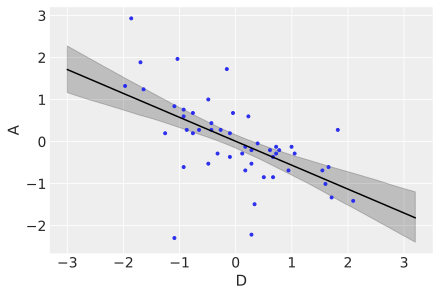

In [6]:
# compute percentile interval of mean
A_seq = np.linspace(start=-3, stop=3.2, num=30)
post = m5_1.sample_posterior(PRNGKey(1), p5_1, (1000,))
post_pred = Predictive(m5_1.model, post).get_samples(PRNGKey(2), A=A_seq)
mu = post_pred["mu"]
mu_mean = np.mean(mu, 0)
mu_PI = np.percentile(mu, q=(5.5, 94.5), axis=0)

# plot it all
az.plot_pair(d[["D", "A"]].to_dict(orient="list"))
plt.plot(A_seq, mu_mean, "k")
plt.fill_between(A_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2);

### Code 5.6

In [7]:
d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std())

def model(M, D=None):
    a = npyro.sample("a", dist.Normal(0, 0.2))
    bM = npyro.sample("bM", dist.Normal(0, 0.5))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a + bM * M
    npyro.sample("D", dist.Normal(mu, sigma), obs=D)

m5_2 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_2, optim.Adam(1), AutoContinuousELBO(),
          M=d.M.values, D=d.D.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p5_2 = svi.get_params(state)

### Code 5.7

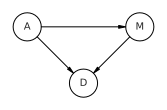

In [8]:
dag5_1 = CausalGraphicalModel(
    nodes=["A", "D", "M"],
    edges=[("A", "D"),
           ("A", "M"),
           ("M", "D")])
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_1.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

### Code 5.8

In [9]:
def model(M, A, D=None):
    a = npyro.sample("a", dist.Normal(0, 0.2))
    bM = npyro.sample("bM", dist.Normal(0, 0.5))
    bA = npyro.sample("bA", dist.Normal(0, 0.5))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a + bM * M + bA * A
    npyro.sample("mu", dist.Delta(mu), obs=mu)
    npyro.sample("D", dist.Normal(mu, sigma), obs=D)

m5_3 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_3, optim.Adam(1), AutoContinuousELBO(),
          M=d.M.values, A=d.A.values, D=d.D.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p5_3 = svi.get_params(state)
post = m5_3.sample_posterior(PRNGKey(1), p5_3, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a     -0.00      0.10     -0.01     -0.16      0.14   1049.96      1.00
        bA     -0.61      0.16     -0.61     -0.86     -0.36    822.38      1.00
        bM     -0.06      0.16     -0.06     -0.31      0.20    984.96      1.00
     sigma      0.80      0.08      0.79      0.68      0.92    970.31      1.00



### Code 5.9

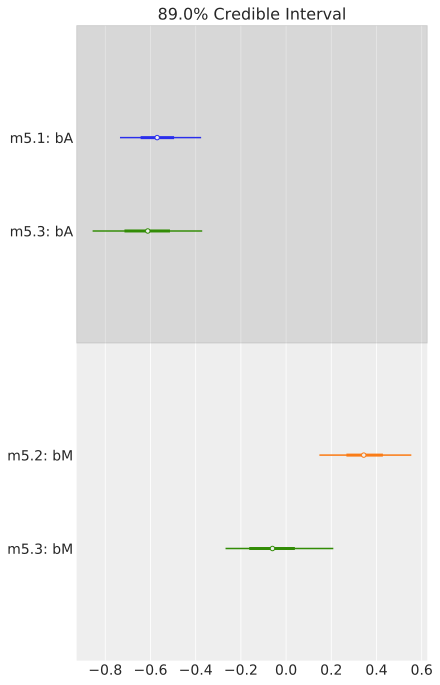

In [10]:
coeftab = {"m5.1": m5_1.sample_posterior(PRNGKey(1), p5_1, (1000,)),
           "m5.2": m5_2.sample_posterior(PRNGKey(2), p5_2, (1000,)),
           "m5.3": m5_3.sample_posterior(PRNGKey(3), p5_3, (1000,))}
az.plot_forest(list(coeftab.values()), model_names=list(coeftab.keys()),
               var_names=["bA", "bM"], credible_interval=0.89);

### Code 5.10

In [11]:
N = 50  # number of simulated States
age = dist.Normal().sample(PRNGKey(0), sample_shape=(N,))  # sim A
mar = dist.Normal(age).sample(PRNGKey(1))  # sim A -> M
div = dist.Normal(age).sample(PRNGKey(2))  # sim A -> D

### Code 5.11

In [12]:
def model(A, M=None):
    a = npyro.sample("a", dist.Normal(0, 0.2))
    bAM = npyro.sample("bA", dist.Normal(0, 0.5))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a + bAM * A
    npyro.sample("mu", dist.Delta(mu), obs=mu)
    npyro.sample("M", dist.Normal(mu, sigma), obs=M)

m5_4 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_4, optim.Adam(0.1), AutoContinuousELBO(),
          A=d.A.values, M=d.M.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p5_4 = svi.get_params(state)

### Code 5.12

In [13]:
post = m5_4.sample_posterior(PRNGKey(1), p5_4, (1000,))
post_pred = Predictive(m5_4.model, post).get_samples(PRNGKey(2), A=d.A.values)
mu = post_pred["mu"]
mu_mean = np.mean(mu, 0)
mu_resid = d.M.values - mu_mean

### Code 5.13

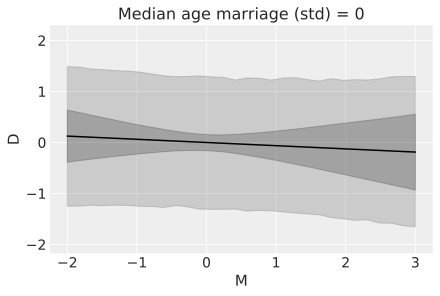

In [14]:
# prepare new counterfactual data
M_seq = np.linspace(start=-2, stop=3, num=30)
pred_data = {"M": M_seq, "A": 0}

# compute counterfactual mean divorce (mu)
post = m5_3.sample_posterior(PRNGKey(1), p5_3, (int(1e4),))
post_pred = Predictive(m5_3.model, post).get_samples(PRNGKey(2), **pred_data)
mu = post_pred["mu"]
mu_mean = np.mean(mu, 0)
mu_PI = np.percentile(mu, q=(5.5, 94.5), axis=0)

# simulate counterfactual divorce outcomes
D_sim = post_pred["D"]
D_PI = np.percentile(D_sim, q=(5.5, 94.5), axis=0)

# display predictions, hiding raw data with alpha=0
az.plot_pair(d[["M", "D"]].to_dict(orient="list"), plot_kwargs={"alpha": 0})
plt.title("Median age marriage (std) = 0")
plt.plot(M_seq, mu_mean, "k")
plt.fill_between(M_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
plt.fill_between(M_seq, D_PI[0], D_PI[1], color="k", alpha=0.15);

### Code 5.14

In [15]:
# call predictive with the original data
post = m5_3.sample_posterior(PRNGKey(1), p5_3, (int(1e4),))
post_pred = Predictive(m5_3.model, post).get_samples(
    PRNGKey(2), M=d.M.values, A=d.A.values)
mu = post_pred["mu"]

# summarize samples across cases
mu_mean = np.mean(mu, 0)
mu_PI = np.percentile(mu, q=(5.5, 94.5), axis=0)

# simulate observations
D_sim = post_pred["D"]
D_PI = np.percentile(D_sim, q=(5.5, 94.5), axis=0)

### Code 5.15

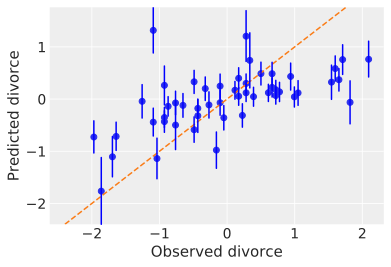

In [16]:
ax = plt.subplot(ylim=(float(mu_PI.min()), float(mu_PI.max())),
                 xlabel="Observed divorce", ylabel="Predicted divorce")
plt.plot(d.D, mu_mean, "o")
x = np.linspace(mu_PI.min(), mu_PI.max(), 101)
plt.plot(x, x, "--")
for i in range(d.shape[0]):
    plt.plot([d.D[i]] * 2, mu_PI[:, i], "b")
fig = plt.gcf()

### Code 5.16

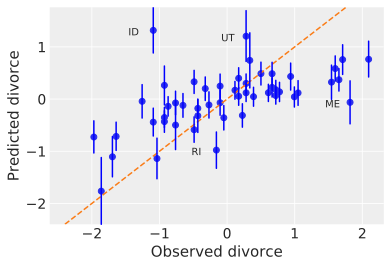

In [17]:
for i in range(d.shape[0]):
    if d.Loc[i] in ["ID", "UT", "RI", "ME"]:
        ax.annotate(d.Loc[i], (d.D[i], mu_mean[i]), xytext=(-25, -5),
                    textcoords="offset pixels")
fig

### Code 5.17

In [18]:
N = 100  # number of cases
# x_real as Gaussian with mean 0 and stddev 1
x_real = dist.Normal().sample(PRNGKey(0), (N,))
# x_spur as Gaussian with mean=x_real
x_spur = dist.Normal(x_real).sample(PRNGKey(1))
# y as Gaussian with mean=x_real
y = dist.Normal(x_real).sample(PRNGKey(2))
# bind all together in data frame
d = pd.DataFrame({"y": y, "x_real": x_real, "x_spur": x_spur})

### Code 5.18

In [19]:
milk = pd.read_csv("../data/milk.csv", sep=";")
d = milk
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 8 columns):
clade             29 non-null object
species           29 non-null object
kcal.per.g        29 non-null float64
perc.fat          29 non-null float64
perc.protein      29 non-null float64
perc.lactose      29 non-null float64
mass              29 non-null float64
neocortex.perc    17 non-null float64
dtypes: float64(6), object(2)
memory usage: 1.9+ KB


,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


### Code 5.19

In [20]:
d["K"] = d["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std())
d["N"] = d["neocortex.perc"].pipe(lambda x: (x - x.mean()) / x.std())
d["M"] = d.mass.pipe(onp.log).pipe(lambda x: (x - x.mean()) / x.std())

### Code 5.20

In [21]:
def model(N, K):
    a = npyro.sample("a", dist.Normal(0, 1))
    bN = npyro.sample("bN", dist.Normal(0, 1))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a + bN * N
    npyro.sample("K", dist.Normal(mu, sigma), obs=K)

with npyro.validation_enabled():
    try:
        m5_5_draft = AutoLaplaceApproximation(model)
        svi = SVI(model, m5_5_draft, optim.Adam(1), AutoContinuousELBO(),
                  N=d.N.values, K=d.K.values)
        init_state = svi.init(PRNGKey(0))
        state, loss = lax.scan(
            lambda x, i: svi.update(x), init_state, np.zeros(1000))
        p5_5_draft = svi.get_params(state)
    except ValueError as e:
        print(str(e))

The parameter loc has invalid values


### Code 5.21

In [22]:
d["neocortex.perc"]

0     55.16
1       NaN
2       NaN
3       NaN
4       NaN
5     64.54
6     64.54
7     67.64
8       NaN
9     68.85
10    58.85
11    61.69
12    60.32
13      NaN
14      NaN
15    69.97
16      NaN
17    70.41
18      NaN
19    73.40
20      NaN
21    67.53
22      NaN
23    71.26
24    72.60
25      NaN
26    70.24
27    76.30
28    75.49
Name: neocortex.perc, dtype: float64

### Code 5.22

In [23]:
dcc = d.iloc[d[["K", "N", "M"]].dropna(how="any", axis=0).index]

### Code 5.23

In [24]:
def model(N, K=None):
    a = npyro.sample("a", dist.Normal(0, 1))
    bN = npyro.sample("bN", dist.Normal(0, 1))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a + bN * N
    npyro.sample("mu", dist.Delta(mu), obs=mu)
    npyro.sample("K", dist.Normal(mu, sigma), obs=K)

m5_5_draft = AutoLaplaceApproximation(model)
svi = SVI(model, m5_5_draft, optim.Adam(0.1), AutoContinuousELBO(),
          N=dcc.N.values, K=dcc.K.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p5_5_draft = svi.get_params(state)

### Code 5.24

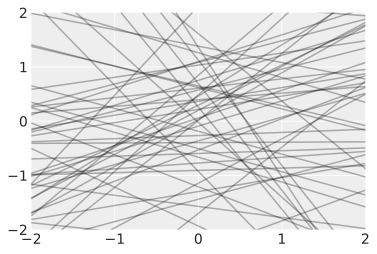

In [25]:
xseq = np.array([-2, 2])
prior_pred = Predictive(model, num_samples=1000).get_samples(
    PRNGKey(1), N=xseq)
mu = prior_pred["mu"]
plt.subplot(xlim=xseq, ylim=xseq)
for i in range(50):
    plt.plot(xseq, mu[i], "k", alpha=0.3)

### Code 5.25

In [26]:
def model(N, K=None):
    a = npyro.sample("a", dist.Normal(0, 0.2))
    bN = npyro.sample("bN", dist.Normal(0, 0.5))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a + bN * N
    npyro.sample("mu", dist.Delta(mu), obs=mu)
    npyro.sample("K", dist.Normal(mu, sigma), obs=K)

m5_5 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_5, optim.Adam(1), AutoContinuousELBO(),
          N=dcc.N.values, K=dcc.K.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p5_5 = svi.get_params(state)

### Code 5.26

In [27]:
post = m5_5.sample_posterior(PRNGKey(1), p5_5, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.05      0.16      0.05     -0.21      0.29    931.50      1.00
        bN      0.13      0.23      0.13     -0.21      0.53   1111.88      1.00
     sigma      1.05      0.18      1.03      0.78      1.35    944.03      1.00



### Code 5.27

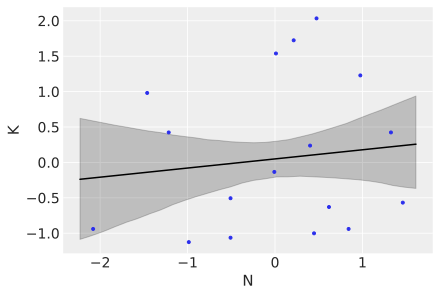

In [28]:
xseq = np.linspace(start=dcc.N.min() - 0.15, stop=dcc.N.max() + 0.15, num=30)
post = m5_5.sample_posterior(PRNGKey(1), p5_5, (1000,))
post_pred = Predictive(m5_5.model, post).get_samples(PRNGKey(2), N=xseq)
mu = post_pred["mu"]
mu_mean = np.mean(mu, 0)
mu_PI = np.percentile(mu, q=(5.5, 94.5), axis=0)
az.plot_pair(dcc[["N", "K"]].to_dict(orient="list"))
plt.plot(xseq, mu_mean, "k")
plt.fill_between(xseq, mu_PI[0], mu_PI[1], color="k", alpha=0.2);

### Code 5.28

In [29]:
def model(M, K=None):
    a = npyro.sample("a", dist.Normal(0, 0.2))
    bM = npyro.sample("bM", dist.Normal(0, 0.5))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a + bM * M
    npyro.sample("mu", dist.Delta(mu), obs=mu)
    npyro.sample("K", dist.Normal(mu, sigma), obs=K)

m5_6 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_6, optim.Adam(1), AutoContinuousELBO(),
          M=dcc.M.values, K=dcc.K.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p5_6 = svi.get_params(state)
post = m5_6.sample_posterior(PRNGKey(1), p5_6, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.06      0.16      0.06     -0.20      0.29    931.50      1.00
        bM     -0.28      0.20     -0.28     -0.61      0.03   1088.44      1.00
     sigma      0.99      0.17      0.98      0.72      1.26    957.10      1.00



### Code 5.29

In [30]:
def model(N, M, K=None):
    a = npyro.sample("a", dist.Normal(0, 0.2))
    bN = npyro.sample("bN", dist.Normal(0, 0.5))
    bM = npyro.sample("bM", dist.Normal(0, 0.5))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a + bN * N + bM * M
    npyro.sample("mu", dist.Delta(mu), obs=mu)
    npyro.sample("K", dist.Normal(mu, sigma), obs=K)

m5_7 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_7, optim.Adam(1), AutoContinuousELBO(),
          N=dcc.N.values, M=dcc.M.values, K=dcc.K.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p5_7 = svi.get_params(state)
post = m5_7.sample_posterior(PRNGKey(1), p5_7, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
         a      0.06      0.13      0.06     -0.15      0.26   1049.96      1.00
        bM     -0.68      0.23     -0.68     -1.06     -0.32    837.54      1.00
        bN      0.65      0.25      0.66      0.25      1.06    885.39      1.00
     sigma      0.77      0.14      0.77      0.55      0.97   1029.58      1.00



### Code 5.30

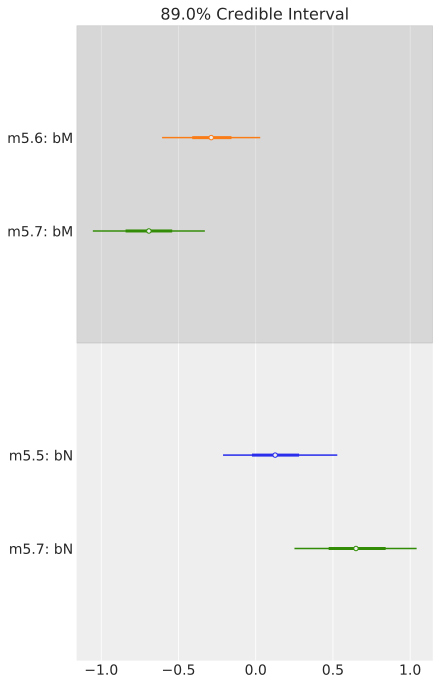

In [31]:
coeftab = {"m5.5": m5_5.sample_posterior(PRNGKey(1), p5_5, (1000,)),
           "m5.6": m5_6.sample_posterior(PRNGKey(2), p5_6, (1000,)),
           "m5.7": m5_7.sample_posterior(PRNGKey(3), p5_7, (1000,))}
az.plot_forest(list(coeftab.values()), model_names=list(coeftab.keys()),
               var_names=["bM", "bN"], credible_interval=0.89);

### Code 5.31

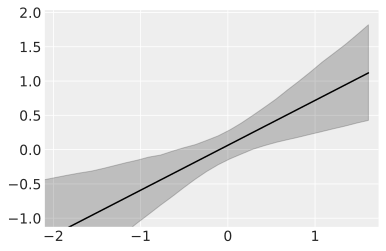

In [32]:
xseq = np.linspace(start=dcc.N.min() - 0.15, stop=dcc.N.max() + 0.15, num=30)
post = m5_7.sample_posterior(PRNGKey(1), p5_7, (1000,))
post_pred = Predictive(m5_7.model, post).get_samples(PRNGKey(2), M=0, N=xseq)
mu = post_pred["mu"]
mu_mean = np.mean(mu, 0)
mu_PI = np.percentile(mu, q=(5.5, 94.5), axis=0)
plt.subplot(xlim=(dcc.M.min(), dcc.M.max()), ylim=(dcc.K.min(), dcc.K.max()))
plt.plot(xseq, mu_mean, "k")
plt.fill_between(xseq, mu_PI[0], mu_PI[1], color="k", alpha=0.2);

### Code 5.32

In [33]:
# M -> K <- N
# M -> N
n = 100
M = dist.Normal().sample(PRNGKey(0), (n,))
N = dist.Normal(M).sample(PRNGKey(1))
K = dist.Normal(N - M).sample(PRNGKey(2))
d_sim = pd.DataFrame({"K": K, "N": N, "M": M})

### Code 5.33

In [34]:
# M -> K <- N
# N -> M
n = 100
N = dist.Normal().sample(PRNGKey(0), (n,))
M = dist.Normal(N).sample(PRNGKey(1))
K = dist.Normal(N - M).sample(PRNGKey(2))
d_sim2 = pd.DataFrame({"K": K, "N": N, "M": M})

# M -> K <- N
# M <- U -> N
n = 100
N = dist.Normal().sample(PRNGKey(3), (n,))
M = dist.Normal(M).sample(PRNGKey(4))
K = dist.Normal(N - M).sample(PRNGKey(5))
d_sim3 = pd.DataFrame({"K": K, "N": N, "M": M})

### Code 5.34

In [35]:
Howell1 = pd.read_csv("../data/Howell1.csv", sep=";")
d = Howell1
d.info()
d.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
height    544 non-null float64
weight    544 non-null float64
age       544 non-null float64
male      544 non-null int64
dtypes: float64(3), int64(1)
memory usage: 17.1 KB


,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


### Code 5.35

In [36]:
mu_female = dist.Normal(178, 20).sample(PRNGKey(0), (int(1e4),))
diff = dist.Normal(0, 10).sample(PRNGKey(1), (int(1e4),))
mu_male = dist.Normal(178, 20).sample(PRNGKey(2), (int(1e4),)) + diff
print_summary({"mu_female": mu_female, "mu_male": mu_male}, 0.89, False)


                 mean       std    median      5.5%     94.5%     n_eff     r_hat
  mu_female    178.21     20.22    178.24    147.19    211.84   9943.61      1.00
    mu_male    178.10     22.36    178.51    142.35    213.41  10190.57      1.00



### Code 5.36

In [37]:
d["sex"] = np.where(d.male.values == 1, 1, 0)
d.sex

0      1
1      0
2      0
3      1
4      0
      ..
539    1
540    1
541    0
542    1
543    1
Name: sex, Length: 544, dtype: int32

### Code 5.37

In [38]:
def model(sex, height):
    a = npyro.sample("a", dist.Normal(178, 20), sample_shape=(len(set(sex)),))
    sigma = npyro.sample("sigma", dist.Uniform(0, 50))
    mu = a[sex]
    npyro.sample("height", dist.Normal(mu, sigma), obs=height)

m5_8 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_8, optim.Adam(1), AutoContinuousELBO(),
          sex=d.sex.values, height=d.height.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(2000))
p5_8 = svi.get_params(state)
post = m5_8.sample_posterior(PRNGKey(1), p5_8, (1000,))
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]    135.02      1.63    135.07    132.32    137.46    931.50      1.00
      a[1]    142.56      1.73    142.54    140.02    145.51   1111.51      1.00
     sigma     27.32      0.84     27.32     26.03     28.71    951.62      1.00



### Code 5.38

In [39]:
post = m5_8.sample_posterior(PRNGKey(1), p5_8, (1000,))
post["diff_fm"] = post["a"][:, 0] - post["a"][:, 1]
print_summary(post, 0.89, False)


                mean       std    median      5.5%     94.5%     n_eff     r_hat
      a[0]    135.02      1.63    135.07    132.32    137.46    931.50      1.00
      a[1]    142.56      1.73    142.54    140.02    145.51   1111.51      1.00
   diff_fm     -7.54      2.38     -7.47    -11.77     -4.32    876.56      1.00
     sigma     27.32      0.84     27.32     26.03     28.71    951.62      1.00



### Code 5.39

In [40]:
milk = pd.read_csv("../data/milk.csv", sep=";")
d = milk
d.clade.unique()

array(['Strepsirrhine', 'New World Monkey', 'Old World Monkey', 'Ape'],
      dtype=object)

### Code 5.40

In [41]:
d["clade_id"] = d.clade.astype("category").cat.codes

### Code 5.41

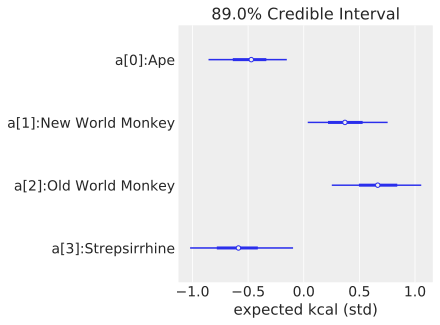

In [42]:
d["K"] = d["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std())

def model(clade_id, K):
    a = npyro.sample("a", dist.Normal(0, 0.5),
                     sample_shape=(len(set(clade_id)),))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a[clade_id]
    npyro.sample("height", dist.Normal(mu, sigma), obs=K)

m5_9 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_9, optim.Adam(1), AutoContinuousELBO(),
          clade_id=d.clade_id.values, K=d.K.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p5_9 = svi.get_params(state)
post = m5_9.sample_posterior(PRNGKey(1), p5_9, (1000,))
labels = ["a[" + str(i) + "]:" + s
          for i, s in enumerate(sorted(d.clade.unique()))]
_, axes = az.plot_forest({"a": post["a"][None, ...]}, credible_interval=0.89)
axes[0].set(yticklabels=labels[::-1], xlabel="expected kcal (std)");

### Code 5.42

In [43]:
onp.random.seed(63)
d["house"] = onp.random.choice(np.repeat(np.arange(4), 8), d.shape[0], False)

### Code 5.43

In [44]:
def model(clade_id, house, K):
    a = npyro.sample("a", dist.Normal(0, 0.5),
                     sample_shape=(len(set(clade_id)),))
    h = npyro.sample("h", dist.Normal(0, 0.5),
                     sample_shape=(len(set(house)),))
    sigma = npyro.sample("sigma", dist.Exponential(1))
    mu = a[clade_id] + h[house]
    npyro.sample("height", dist.Normal(mu, sigma), obs=K)

m5_10 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_10, optim.Adam(1), AutoContinuousELBO(),
          clade_id=d.clade_id.values, house=d.house.values, K=d.K.values)
init_state = svi.init(PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, np.zeros(1000))
p5_10 = svi.get_params(state)